In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

import utils
import multiqlearning
import replay
import actions

In [3]:
seed = 42
map_size = 4
max_interactions = 1024*128
map_scale = int(jnp.log2(map_size))

# hyperparams
rollout_length = 2 * map_size**2
n_rollouts = max_interactions // rollout_length
train_iter = 8
lr = 3e-4

q_learning_step = partial(
    multiqlearning.multi_q_learning_step, rollout_length=rollout_length, train_iter=train_iter
)

In [4]:
# @partial(jax.jit, static_argnames=("map_size", "lr", "replay_capacity"))
def setup_simulation(rng_key, map_size, lr, replay_capacity):
    rng_env, rng_dql = jax.random.split(rng_key)
    # env = utils.FrozenLake.make_random(rng_env, (map_size, map_size), 0.8)
    env = utils.FrozenLake.make_preset(rng_env, (map_size, map_size))

    reward_fn = actions.get_reward_fn(cell_size=(2, 2))
    beta_fn = actions.get_beta_fn(cell_size=(2, 2))

    env_state, obs = env.reset(rng_key)
    action = env.action_space.sample(rng_key)
    sample_transition = utils.Transition(env_state, obs, action, 0.0, obs, False, {})
    sample_transition = sample_transition.replace(reward=reward_fn(sample_transition))

    MultiConvNet = nn.vmap(
        utils.ConvNet,
        in_axes=None,
        variable_axes={"params": 0},
        split_rngs={"params": True},
        axis_size=5,
    )

    qnet = MultiConvNet(hidden=[2 * map_size] * int(np.log2(map_size)), out=env.action_space.n)
    dql_state = multiqlearning.MultiDQLTrainState.create(
        rng_dql, qnet, obs, lr, reward_fn=reward_fn, beta_fn=beta_fn
    )
    replay_memory = replay.CircularBuffer.create(sample_transition, replay_capacity)
    return (env, dql_state, replay_memory)

In [5]:
rng_key = jax.random.PRNGKey(seed)

@jax.jit
def run_sim(rng_key):
    rng_init, rng_sim = jax.random.split(rng_key)
    rng_sim = jax.random.split(rng_sim, n_rollouts)
    (env, dql_state, replay_memory) = setup_simulation(rng_init, map_size, lr, replay_capacity=2**14)
    (env, dql_state, replay_memory), results = jax.lax.scan(q_learning_step, (env, dql_state, replay_memory), rng_sim)
    return env, dql_state, results

env, dql_state, results = run_sim(rng_key)

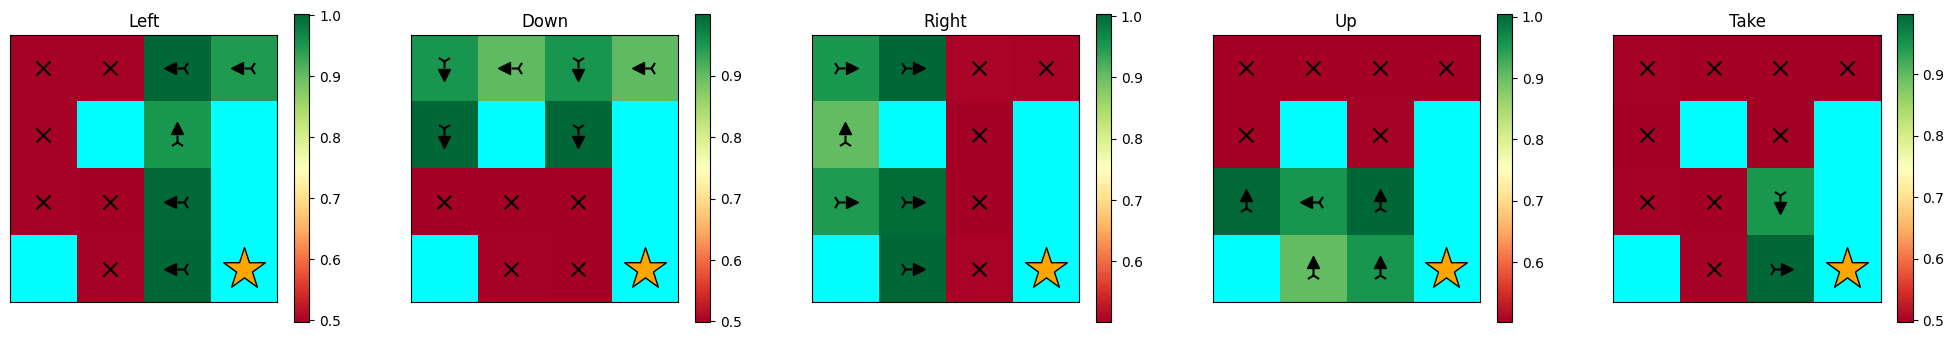

In [6]:
import matplotlib.pyplot as plt
import plotting

rng_key = jax.random.PRNGKey(0)
rng_env_reset, rng_steps = jax.random.split(rng_key)

plt.figure(figsize=((map_size + 1) * 5, map_size))
for task_id, task_name in enumerate(("Left", "Down", "Right", "Up", "Take")):
    plt.subplot(1, 5, task_id + 1)
    plt.title(task_name)
    get_qval_fn = lambda obs: dql_state.qval_apply_fn(dql_state.params_qnet, obs)[task_id]
    plotting.plot_qvals(env, get_qval_fn, rng_reset=rng_env_reset, hold=True)

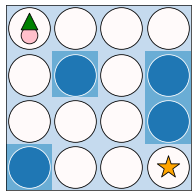

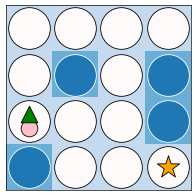

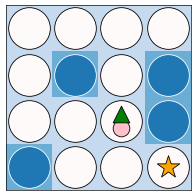

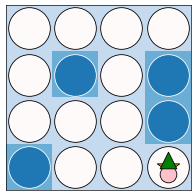

In [7]:
from mangoenv import MangoEnv

mango_env = MangoEnv(env, dql_state)
mango_state, obs = mango_env.reset(rng_key)
plotting.render(mango_env.lower_layer, mango_state.env_state)

for comand in [1, 2, 4]:
    mango_state, obs, reward, done, info = mango_env.step(mango_state, rng_key, comand)
    plotting.render(mango_env.lower_layer, mango_state.env_state)